# Toy Example

This is a toy example of the proposed model using pyMC3.

In [1]:
import numpy as np
import scipy as sp
import pymc3 as pm
from theano import tensor as tt
import datetime
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Read in the Data

Toy data was generated with 2 regions, 1 lag time, 400 time observations per subject, 4 measured covariates per subject, and 100 subjects. This will result in a 2x2 graph, where each node represents how time t-1 influences time t for region 1 and 2. The following steps were used:
    1. set group mean, Omega, to (0,1,-1,1)
    2. for each subject, generate measured covariates. Covariate 1 from a random uniform(0,1), covariates uniform(-3,3), covariate 3 uniform(0,1), and covariate 4 binomial(0.5). Note that the function for each edge is the same.
    3. generate edge strength i as. Each edge strength was equal to (cov1^5) - (0.2 * sin(cov2) ) - (0.1 * log(cov3)) - (0.3 * cov4) + omega_i
    4. generate observed measurements using edge strength values generated in (3) and adding random noise

In [2]:
IUs = np.load("/home/nathan/Documents/Fun/VAR_Data/IUs_GP4.npy")
Xs = np.load("/home/nathan/Documents/Fun/VAR_Data/Xs_GP4.npy")
covs = np.load("/home/nathan/Documents/Fun/VAR_Data/covs_GP4.npy")
true = np.load("/home/nathan/Documents/Fun/VAR_Data/alpha_GP4.npy")

#### Get data shape and prepare data to be used in model

In [3]:
Ns = Xs.shape[0]
Subs = Xs.shape[1]
Bs = IUs.shape[1]
observed_data = [Xs[:,i] for i in range(Subs)]

# Variational Inference Model

pyMC3 can only use variational inference on continuous data, and so instead of using a spike and slab, the group means are independent Laplace distributions. A spike and slibe prior, with HMC sampling will be shown below.

In [4]:
basic_model = pm.Model()

with basic_model:
    
    ## group level
    omega = pm.Laplace('group_B',mu = 0,b = 0.1,shape = Bs)
#     gamma = pm.Bernoulli('gamma', 0.5, shape = Bs)

    lengthscale = [1,1,1,1]
    eta = 1.0
    cov = eta**2 * pm.gp.cov.ExpQuad(4, lengthscale)
    gp = [pm.gp.Latent(pm.gp.mean.Constant(c=omega[i]),cov_func=cov) for i in range(Bs)]
    f = tt.stack([gp[i].prior('f' + str(i),X = covs) for i in range(Bs)],0)
    sigma = pm.HalfNormal('sigma', sd=1,shape =1)

    # Expected value of outcome
    mus = [pm.math.dot(IUs[:,:,i],f[:,i])   for i in range(Subs)]

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mus, sd=sigma, observed=observed_data)
    
    mp = pm.find_MAP()

/home/nathan/anaconda2/lib/python2.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.1343e+05, ||grad|| = 31.791: 100%|██████████| 402/402 [00:04<00:00, 99.18it/s]   


## Graphical Representaion of the Model

f0 - f4 are the GP(group_mean,Cov(covariates))

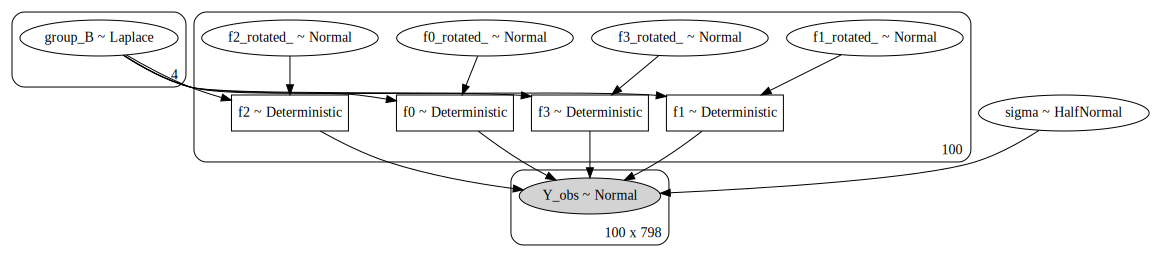

In [5]:
pm.model_to_graphviz(basic_model)

In [6]:
with basic_model:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method=inference)
trace = approx.sample(draws=5000)

Average Loss = 1.2538e+05: 100%|██████████| 10000/10000 [01:18<00:00, 127.88it/s]
Finished [100%]: Average Loss = 1.2535e+05


## mean and standard deviation of group means
The true means are (0,1,-1,0). The estimated means are close. I would guess using a spike and slab would give more accurate results.

In [7]:
print('group means',np.mean(trace[omega],0))
print('group means sd',np.std(trace[omega],0))

('group means', array([ 0.05069711,  0.48659564, -0.39556269,  0.05626023]))
('group means sd', array([0.1634034 , 0.17302418, 0.16718887, 0.1577484 ]))


We will now use new covariates to get the effects of each covariate on edge strengths. To get the effect of covariate 1, we will generate a new covariate matrix where the measurements for covariate 1 are a sequence from 0 to 1, and the measurements for all other covariates are 0. We will randomly draw new GPs using these covariates and repeat this process for all other covariates.

In [8]:
n_new = 100
covs1_new = np.zeros((n_new,4))
covs1_new[:,0] = np.linspace(0,1,n_new)
covs2_new = np.zeros((n_new,4))
covs2_new[:,1] = np.linspace(-3,3,n_new)
covs3_new = np.zeros((n_new,4))
covs3_new[:,2] = np.linspace(0,1,n_new)
covs4_new = np.zeros((2,4))
covs4_new[1,3] = 1

In [9]:
means = {}
for i in mp.keys():
    means[i] = np.mean(trace[i],0) 

with basic_model:
    f0_c0 = gp[0].conditional("f0_c0", Xnew = covs1_new)
    f0_c1 = gp[0].conditional("f0_c1", Xnew = covs2_new)
    f0_c2 = gp[0].conditional("f0_c2", Xnew = covs3_new)
    f0_c3= gp[0].conditional("f0_c3", Xnew = covs4_new)

with basic_model:
    pred_samples = pm.sample_posterior_predictive([means], vars=[f0_c0,f0_c1,f0_c2,f0_c3], samples=2000)

100%|██████████| 2000/2000 [01:10<00:00, 28.24it/s]


## plot each covariates marginal effects for edge (1,1)
true function is in orange, while estimated function is in blue.

As we can see, the GP recovers the general shape of the functions. One thing that may be causing more flat functions for covariate 1 and 3 are the the tails being more sharp. If there were more subjucts near the tails, the results may be a little better. The results may also be better with different length_scales in the covariance function.

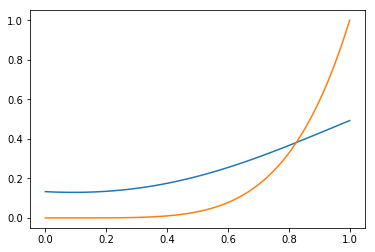

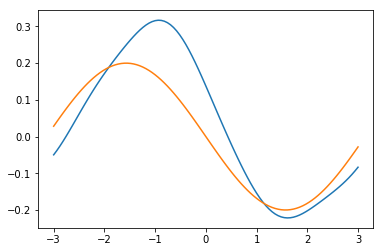

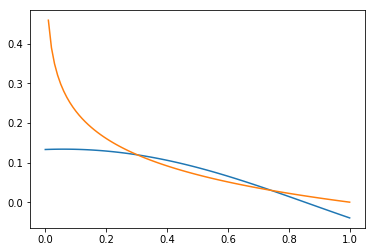

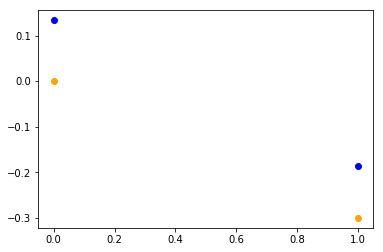

In [10]:
plt.plot(covs1_new[:,0],np.mean(pred_samples['f0_c0'],0))
plt.plot(covs1_new[:,0],covs1_new[:,0]**5)
plt.show()

plt.plot(covs2_new[:,1],np.mean(pred_samples['f0_c1'],0))
plt.plot(covs2_new[:,1],-np.sin(covs2_new[:,1])/5)
plt.show()

plt.plot(covs3_new[:,2],np.mean(pred_samples['f0_c2'],0))
plt.plot(covs3_new[:,2],-np.log(covs3_new[:,2])/10)
plt.show()

plt.plot(covs4_new[:,3],np.mean(pred_samples['f0_c3'],0),'ro',c = 'blue')
plt.plot(covs4_new[:,3],-covs4_new[:,3]*.30,'ro',c = 'orange')
plt.show()

## plot each effect for the observed data using the true underlying functions

We plot the effects each covariate has on the edge strength, subtracting the true effect from each covariate. The true functions are plotted in red and estimated values are in blue.

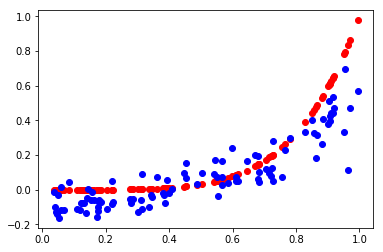

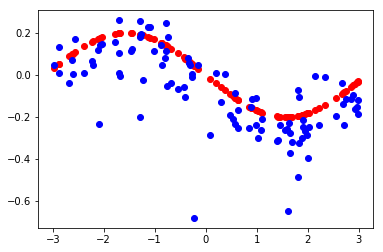

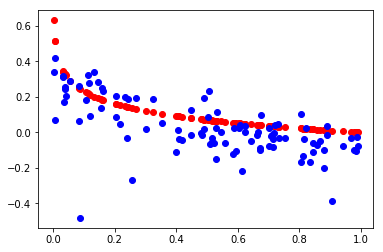

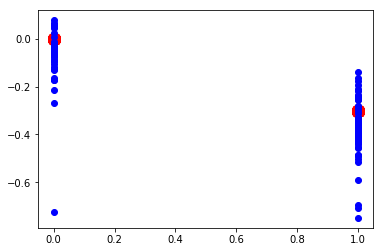

In [11]:
plt.plot(covs[:,0],covs[:,0]**5,'ro')
plt.plot(covs[:,0],np.mean(trace['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) + 0.1*np.log(covs[:,2]) + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,1],-np.sin(covs[:,1])/5,'ro')
plt.plot(covs[:,1],np.mean(trace['f0'],axis = 0) - covs[:,0]**5 + 0.1*np.log(covs[:,2]) + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,2],-np.log(covs[:,2])/10,'ro')
plt.plot(covs[:,2],np.mean(trace['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) - covs[:,0]**5 + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,3],-covs[:,3]*0.3,'ro',markersize=12)
plt.plot(covs[:,3],np.mean(trace['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) + 0.1*np.log(covs[:,2]) - covs[:,0]**5,'ro',color = 'blue')
plt.show()


# Spike and Slab and HMC

In [13]:
MCMC_model = pm.Model()

with MCMC_model:
    
    ## group level
    omega = pm.Normal('group_B',mu = 0,sd = 1,shape = Bs)
    gamma = pm.Bernoulli('gamma', 0.5, shape = Bs)

    lengthscale = [1,1,1,1]
    eta = 1.0
    cov = eta**2 * pm.gp.cov.ExpQuad(4, lengthscale)
    gp = [pm.gp.Latent(pm.gp.mean.Constant(c=omega[i]*gamma[i]),cov_func=cov) for i in range(Bs)]
    f = tt.stack([gp[i].prior('f' + str(i),X = covs) for i in range(Bs)],0)
    sigma = pm.HalfNormal('sigma', sd=1,shape =1)

    # Expected value of outcome
    mus = [pm.math.dot(IUs[:,:,i],f[:,i])   for i in range(Subs)]

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mus, sd=sigma, observed=observed_data)
    
    mp = pm.find_MAP()

logp = -1.1344e+05, ||grad|| = 2.1993: 100%|██████████| 524/524 [00:05<00:00, 98.79it/s]    


In [14]:
with MCMC_model:
    trace_MCMC = pm.sample(1000,tune = 8000,progressbar = True,chains = 2,target_accept = 0.80)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, f3_rotated_, f2_rotated_, f1_rotated_, f0_rotated_, group_B]
>BinaryGibbsMetropolis: [gamma]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
print('group means',np.mean(trace_MCMC[omega],0))
print('PPI',np.mean(trace_MCMC[gamma],0))
print('group means sd',np.std(trace_MCMC[omega],0))

('group means', array([ 0.00645713,  1.61387036, -0.00442832,  0.44329832]))
('PPI', array([0.01  , 1.    , 0.0035, 0.5015]))
('group means sd', array([0.97130634, 0.35118872, 1.04299756, 0.87654684]))


In [16]:
n_new = 100
covs1_new = np.zeros((n_new,4))
covs1_new[:,0] = np.linspace(0,1,n_new)
covs2_new = np.zeros((n_new,4))
covs2_new[:,1] = np.linspace(-3,3,n_new)
covs3_new = np.zeros((n_new,4))
covs3_new[:,2] = np.linspace(0,1,n_new)
covs4_new = np.zeros((2,4))
covs4_new[1,3] = 1

In [17]:
means = {}
for i in mp.keys():
    means[i] = np.mean(trace_MCMC[i],0) 

with MCMC_model:
    f0_c0 = gp[0].conditional("f0_c0", Xnew = covs1_new)
    f0_c1 = gp[0].conditional("f0_c1", Xnew = covs2_new)
    f0_c2 = gp[0].conditional("f0_c2", Xnew = covs3_new)
    f0_c3= gp[0].conditional("f0_c3", Xnew = covs4_new)

with MCMC_model:
    pred_samples = pm.sample_posterior_predictive([means], vars=[f0_c0,f0_c1,f0_c2,f0_c3], samples=2000)

100%|██████████| 2000/2000 [01:15<00:00, 26.48it/s]


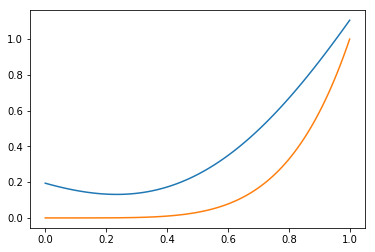

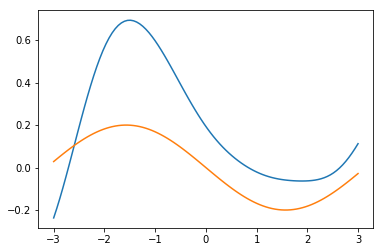

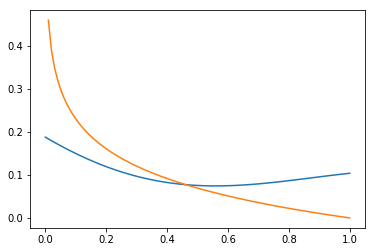

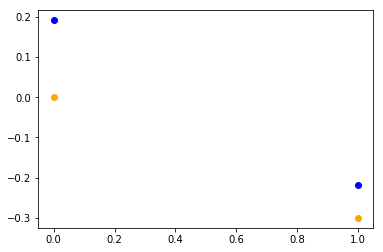

In [18]:
plt.plot(covs1_new[:,0],np.mean(pred_samples['f0_c0'],0))
plt.plot(covs1_new[:,0],covs1_new[:,0]**5)
plt.show()

plt.plot(covs2_new[:,1],np.mean(pred_samples['f0_c1'],0))
plt.plot(covs2_new[:,1],-np.sin(covs2_new[:,1])/5)
plt.show()

plt.plot(covs3_new[:,2],np.mean(pred_samples['f0_c2'],0))
plt.plot(covs3_new[:,2],-np.log(covs3_new[:,2])/10)
plt.show()

plt.plot(covs4_new[:,3],np.mean(pred_samples['f0_c3'],0),'ro',c = 'blue')
plt.plot(covs4_new[:,3],-covs4_new[:,3]*.30,'ro',c = 'orange')
plt.show()

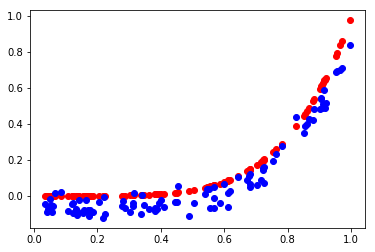

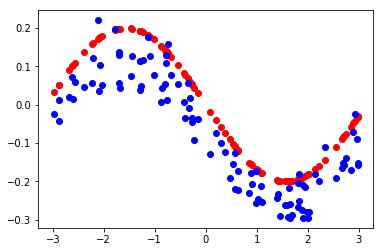

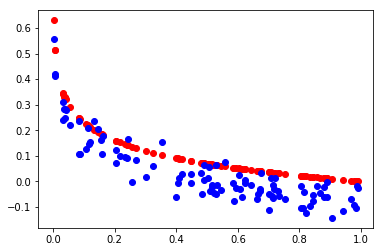

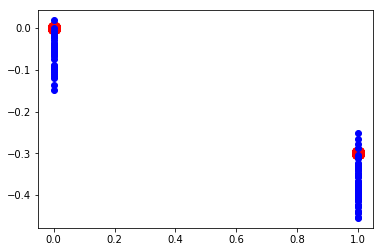

In [19]:
plt.plot(covs[:,0],covs[:,0]**5,'ro')
plt.plot(covs[:,0],np.mean(trace_MCMC['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) + 0.1*np.log(covs[:,2]) + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,1],-np.sin(covs[:,1])/5,'ro')
plt.plot(covs[:,1],np.mean(trace_MCMC['f0'],axis = 0) - covs[:,0]**5 + 0.1*np.log(covs[:,2]) + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,2],-np.log(covs[:,2])/10,'ro')
plt.plot(covs[:,2],np.mean(trace_MCMC['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) - covs[:,0]**5 + covs[:,3]*0.3,'ro',color = 'blue')
plt.show()

plt.plot(covs[:,3],-covs[:,3]*0.3,'ro',markersize=12)
plt.plot(covs[:,3],np.mean(trace_MCMC['f0'],axis = 0) + 0.2*np.sin(covs[:,1]) + 0.1*np.log(covs[:,2]) - covs[:,0]**5,'ro',color = 'blue')
plt.show()
